# Welcome To Smart Home System

The system is implemented to make home owner only can control Home door, or any other part, with a pre-defined gestures, Swiping Right and Left in my case to open and close the door accordingly.

# Models Used



Face Detection: BlazeFace _by mediapipe 

Face Recognition: FaceNet Converted to TensorFlow Lite to make raspberry pi 4 able to run it

Hand gestures Recognition: MediaPipe Hands 

# Multi-Threading

The process of face recognition is too heavy, so I decided not to run it all the time

Thus The system use multi-threading 

Thread 1:- For hand gestures recognition process

Thread 2:- For Face recognition process 

Thread 3:- For face detection process , this thread targets if there a guest's face detected in front of the camera making no gesture for 15 seconds.

Thread 1 runs all the time , thread 3  runs every 5 seconds for one second and thread 3 runs when thread 1 or 2 calls it when it is necessary.



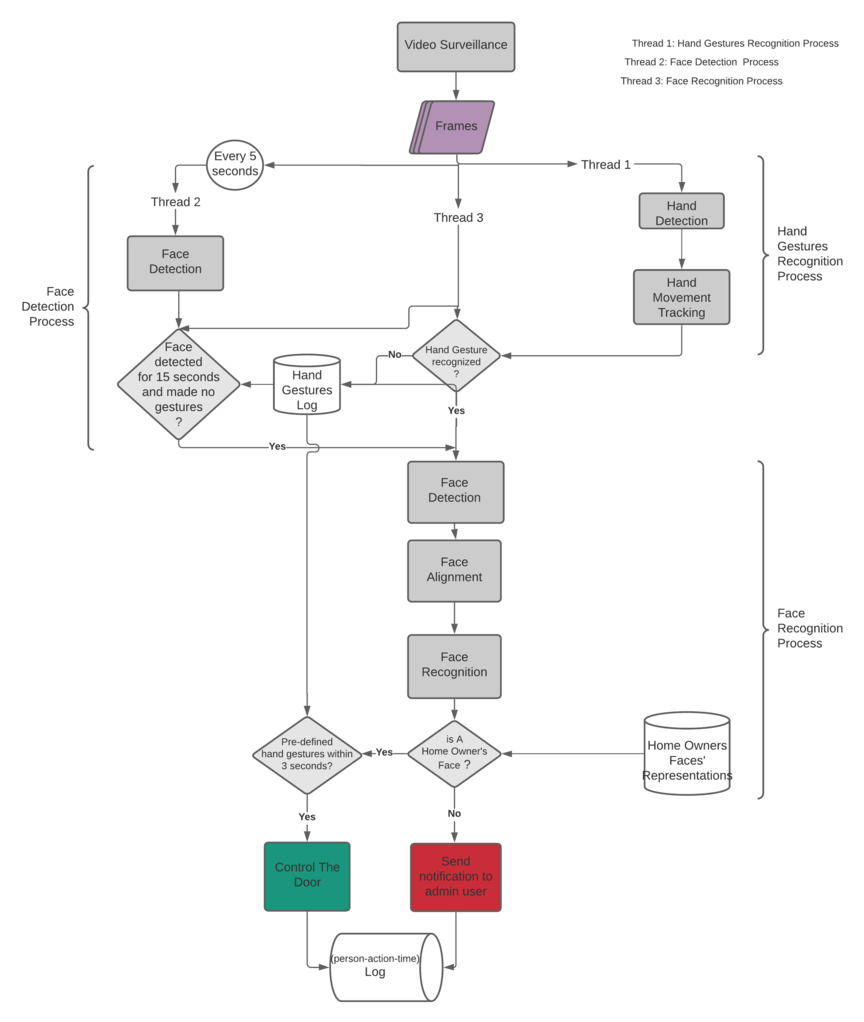

In [1]:
import os
from IPython import display
display.Image(os.getcwd()+"/mutlithreading.png")

# System results

The system can recognize detect and recognize mutiple faces per a frame But only a hand. 


It can Run from 20 to 100+ FPS on laptop with 16 GB ram and core i7 -10th gen process

It  can Run from 2 to 15 FPS on Raspberry pi 4 model 

Change in FPS depends on which threads is running


# Importing necessary packages

In [2]:
import numpy as np
import mediapipe as mp
import os
from os import path,listdir
import cv2
import time
import math
from PIL import Image
import pandas as pd
import threading
from datetime import datetime , date
from statistics import mode
import sys
import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing.image import load_img, save_img, img_to_array
print("packages loaded Successfully")

C:\Users\RC\.conda\envs\ML\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\RC\.conda\envs\ML\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\RC\.conda\envs\ML\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


packages loaded Successfully


In [3]:
db_path =os.getcwd() 
threshold =10 # from 9 ~ 10 

DataBase should has persons' named images

In [4]:
#Create models and get representations ------
import CreateFacenet
interpreter , input_details ,output_details = CreateFacenet.GetTheModel(db_path)
employees = []
import CreateDB 
employees =CreateDB.Create_DB(employees,db_path,interpreter , input_details ,output_details)


FaceNet builded successfully in TFlite in 0.1 seconds
Thus, if you added new instances after this file creation, then please delete this file and call find function again. It will create it again.
C:\Users\RC\Desktop\Face And Hand Gestures Recognition/HomeOwners/representations.pkl rb
There are  29  representations found in  representations.pkl


In [5]:
class Face_Process :   # A class is used mainly for Face Recognition and checking if the person made a gesture within a time window
    #variables needed
    faces = [] # an array save the faces appeard in every frame for 1.5 seconds and then deleted
    Reco = False # a bool variable indicate if recognition process started
    StarAT=-1 # timing variable indicate when recognition process started
    ids=0 # int variable to contain how many person in the frame
    Who="" # String variable includes the names of the persons recognized and unkowns 
    AAction= False # means recognition process done 
    outputs=[] # contains boundind box dimensions and person's name/ unkown to be shown in output frame


    FlagHomeOwner =False
    FlagOpen = False
    FlagClose = False
    FlagNotPRed= False 
    MakeAgesture=False
    endsignal = False

    faceDetection = mp.solutions.face_detection.FaceDetection(0.8) # mediapipe_BlazeFace  

    #-------

    def findEuclideanDistance(self,source_representation, test_representation):  # get EuclideanDistance between source_representation, anotherrepresentation
        euclidean_distance = source_representation - test_representation
        euclidean_distance = np.sum(np.multiply(euclidean_distance, euclidean_distance))
        euclidean_distance = np.sqrt(euclidean_distance)
        return euclidean_distance
    #--------

    def makeDecision(self):  # Check whether a home owner or guest that made the hand gesture
        pivot = 0 
        while pivot < len(self.faces):  
            if(self.faces[pivot][1] >=  self.StarAT):
                break 
            pivot =pivot+1

        tempdf= self.faces[ pivot : len(self.faces)]  # Faces recognized in timeToRecognition seconds
        self.faces =[]
        TmpArr= [] 
        countunkowns =0 
        FoundOwner= False
        for id in range(self.ids) : 
            temp2df =[]
            for item in tempdf :
                if(item[2]==id):
                    temp2df.append(item[0])

            if(len(temp2df)!=0):     
                The_real_person=mode(temp2df)
                TmpArr.append(The_real_person)
                if(The_real_person != "unknown"):
                    FoundOwner=True 
                else:
                    countunkowns = countunkowns+1


        if(self.ids!=0 ):
            self.AAction=True
        Gesture_Time_window = 4
        if(FoundOwner):
            self.FlagHomeOwner = True 
            def listToString(s): 
                str1 = s[0]
                for ele in s[1:len(s)]: 
                    str1 =str1+ " and " +ele  
                return str1 
            self.Who =  listToString(TmpArr)
            TmpArr =[] 
            if(len(HP.Real_data) != 0):
                gesture_T = HP.Real_data[len(HP.Real_data)-1]
                T = HP.Real_data[len(HP.Real_data)-1][1]
                if(self.StarAT -T <= Gesture_Time_window):
                    gesture=gesture_T[0]
                    if (gesture == 'Swiping Right'):
                        self.FlagOpen = True 
                    elif  (gesture == 'Swiping Left'):
                        self.FlagClose = True 
                    elif(gesture == 'NOT a predifiend Gesture'):
                        self.FlagNotPRed =True

        else:
            self.Who =str(countunkowns)+ " unknown\s"
            if(len(HP.Real_data) != 0):
                tempgestTime= HP.Real_data[len(HP.Real_data)-1][1]
                if(self.StarAT-tempgestTime <=  Gesture_Time_window):
                    self.MakeAgesture =True
                else :
                    self.MakeAgesture =False

        self.endsignal=True
        self.StarAT = -1
        self.Reco= False


    def FaceReco(self,img,HP): # recognition process
        timeToRecognition =1.5
        if(self.Reco == True and (time.time() - self.StarAT >=timeToRecognition) and  self.StarAT !=-1 ): #takes timeToRecognition seconds to make a perfect recognition
            self.makeDecision()

        else:
            #----- Face Detection 
            results = self.faceDetection.process(img)
            ih, iw, _ = img.shape


            if results.detections:
                self.ids = len (results.detections)
                for id, detection in enumerate(results.detections): 
                    bboxC = detection.location_data.relative_bounding_box
                    x=int(bboxC.xmin * iw)
                    y=int(bboxC.ymin * ih)
                    w =int(bboxC.width * iw)
                    h =int(bboxC.height * ih)
                    bboxC =0 
                    results =[] 
                    if(x<0):
                        x= 0 
                    if(y<0):
                        y=0 


                    left_eye_center=(int(detection.location_data.relative_keypoints[0].x * iw) , int(detection.location_data.relative_keypoints[0].y * ih))
                    right_eye_center=(int (detection.location_data.relative_keypoints[1].x * iw) , int(detection.location_data.relative_keypoints[1].y * ih))

                    detected_face = img[int(y):int(y+h), int(x):int(x+w)] #crop detected face

            #-----------Face Alignment 
                    left_eye_x = left_eye_center[0]; left_eye_y = left_eye_center[1]
                    right_eye_x = right_eye_center[0]; right_eye_y = right_eye_center[1]



                    if left_eye_y > right_eye_y:

                        point_3rd = (right_eye_x, left_eye_y)
                        direction = -1 #rotate same direction to clock
                    else:

                        point_3rd = (left_eye_x, right_eye_y)
                        direction = 1 #rotate inverse direction of clock
                        #print("rotate to inverse clock direction")

                    def euclidean_distance(a, b):
                        x1 = a[0]; y1 = a[1]
                        x2 = b[0]; y2 = b[1]
                        return math.sqrt(((x2 - x1) * (x2 - x1)) + ((y2 - y1) * (y2 - y1)))
                    a = euclidean_distance(left_eye_center, point_3rd)
                    b = euclidean_distance(right_eye_center, left_eye_center)
                    c = euclidean_distance(right_eye_center, point_3rd)

                    if(b  !=0 and c !=0 ):
                        cos_a = (b*b + c*c - a*a)/(2*b*c)


                        angle = np.arccos(cos_a)


                        angle = (angle * 180) / math.pi

                        if direction == -1:
                            angle = 90 - angle
                        new_img = Image.fromarray(detected_face)
                        new_img = np.array(new_img.rotate(direction * angle))
                    else :
                        new_img = Image.fromarray(detected_face)
                        new_img = np.array(new_img)


             #-----------Feature Extraction
                    detected_face =[] 
                    new_img = cv2.resize(new_img, (160, 160)) 
                    img_pixels = np.expand_dims(new_img, axis = 0)
                    new_img=[]
                    mean, std = img_pixels.mean(), img_pixels.std()
                    img_pixels = (img_pixels-mean)/std
                    img_pixels= np.array(img_pixels, dtype=np.float32)
                    interpreter.set_tensor(input_details[0]['index'],img_pixels )
                    interpreter.invoke()
                    captured_representation = interpreter.get_tensor(output_details[0]['index'])
                    K.clear_session()
                    img_pixels=[]
                    label_name = 'unknown'
                    for i in employees:
                        employee_name = i[0]
                        source_representation = i[1]
                        distance = self.findEuclideanDistance(captured_representation, source_representation)
                        if distance <= threshold:
                            label_name = employee_name
                            captured_representation =[] 
                            break

                    at = time.time()    

                    if(self.Reco!= True):
                        self.StarAT=at
                        self.Reco= True

                    self.faces.append((label_name,at,id))
                    self.outputs.append((x,y,w,h,label_name))


In [6]:
# _Mobile App 
import FCMManager as fcm


import cloudstorage 
storage,db  = cloudstorage.start()


def DBHomeowners():
    db.child("homeowners").remove()
    HomeownerPath=db_path+"/"+"HomeOwners"
    for employee in listdir(HomeownerPath):
        if(employee != 'representations.pkl'):
            #print("upload",employee )
            db.child("homeowners").push({"name" :employee   })
            

DBHomeowners()               
    


def notify(msg,counterguest):
    token = ["dfUj_ISOQuaPzVvFychbyv:APA91bFKxA3ldNKHgA0W4c_yAZ1HFyZTfjUS8rtB_Xb-FbLyFWy7e3GS_iHmpJ9gHsAkmrm6ObTyOfTDpub5iPE2tgOr_M7kr4IRf6SVdyMRunQn7sbav87gXAP-b_e84HftSCgcVTz_"]
    fcm.sendPush("Smart Door Notification",msg, token , "guest"+str(counterguest)+".jpg")
    db.child("notification").remove()
    db.child("notification").push({"notification" : "yes"})
    
    
#-----------------------




def upload_image_To_Cloud_AND_PC(imgname , frame,counterguest):
    cv2.imwrite(imgname, frame)
    storage.child("guest"+str(counterguest)+".jpg").put(imgname)
    frame =[] 
    #print("guest"+str(counterguest)+".jpg" , " uploaded")
    
    

#-----------------




In [7]:
class solenoidPI:
    Flag=True
    solenoid_State ='close'

    def open(self):
        #import RPi.GPIO as GPIO
        #LED_PIN = 17
        #GPIO.setwarnings(False) 
        #GPIO.setmode(GPIO.BCM)
        #GPIO.setup(LED_PIN, GPIO.OUT)
        print("solenoid is opening")

        while(self.Flag):
             pass # PC_has no_control _to Solenoid


       # print("solenoid  closed")


        #GPIO.cleanup()



    def close(self):
        self.Flag = False
        print("solenoid  closed")

class FireDB :
    systemOnFlag = True;
    counterguest = 1

    def checkdb(self):
        if(db.child("smartdoor").get().val()):
            action =db.child("smartdoor").get().val()
            db.child("smartdoor").remove()
            if(action == 'open'):
                if(solenoid.solenoid_State == 'close'):
                    solenoid.solenoid_State = 'open'
                    solenoid.Flag=True
                    t7 = threading.Thread(target= solenoid.open , args = ())
                    t7.start()
                else :
                    print("The door is already open")

            else:
                if(solenoid.solenoid_State == 'open'):
                    solenoid.solenoid_State = 'close'
                    t7 = threading.Thread(target= solenoid.close , args = ())
                    t7.start()
                else:
                    print("The door is already closed")


        if(db.child("appsystem").get().val()):
            system =db.child("appsystem").get().val()
            db.child("appsystem").remove()
            if(system == 'systemOff'):
                #print("system of pushed")
                self.systemOnFlag= False




def goUpdateLOG(who , action , time):

    db.child("log").push({"person" :who, "action" : action , "time": time})



In [21]:


FP=Face_Process() 

firedb =FireDB()

solenoid = solenoidPI()


import FDetectionProcess 
FD  = FDetectionProcess.FDetection()

import HandProcess
HP=HandProcess.Hand_Process()



def runsystem():
    timer= -1
    ended = -1
    Flag = False
    last_action = -1 

    DBchecker= -1 

    db.child("system").remove()
    db.child("system").push({"state" : "open"})



    if(db.child("smartdoor").get().val()):
        db.child("smartdoor").remove()



    capture = cv2.VideoCapture(0)
    MsgOnScreen="Video Surveillance"
    MsgOnScreenStartAt=-1


    while(True):

        list_threads = []
        LOG = pd.DataFrame({'person\s' : [],'Action':[],'time':[]})
        FD.outputs =[]
        FP.outputs =[]
        HP.outputs =[] 
        HP.tracked_point = 0 


        ret, img = capture.read()
        if img is None:
            pass
        #print(img.shape)
        frame = img .copy()
        STime = time.time()  

    #----------------------- Multi-Threading part   


        t2= threading.Thread(target=FP.FaceReco, args = (img,HP,))
        t1 = threading.Thread(target= HP.Hand, args = (frame,))
        t3 = threading.Thread(target= FD.blazeface, args = (img,HP,))

        if( time.time() - DBchecker>=2 and FP.Reco == False):
            t5 = threading.Thread(target= firedb.checkdb, args = ())
            t5.start()
            DBchecker = time.time()
            #print("dbcecker thread started")



        if( FP.endsignal == False and HP.Startreco !=-1 and t2.is_alive()==False ): 
            HP.makeFDsleep =True 
            FD.makeHPsleep =True 
            t2.start()
            list_threads.append(t2)

            #print("face reco thread started")


        
        
        if((FP.endsignal or time.time() - HP.Startreco >7) and HP.Startreco !=-1  ):
            HP.Startreco=-1
            FP.StarAT = -1
            FP.Reco= False
            HP.makeFDsleep =False    
            FD.makeHPsleep =False
            FP.endsignal = False
            #print("face reco thread ended")


        if(FD.Startreco != -1 and FP.endsignal == False and t2.is_alive()==False ):
            FD.makeHPsleep =True 
            HP.makeFDsleep= True
            t2.start()
            list_threads.append(t2)
            #print("face reco thread started")

        if (FD.Startreco != -1 and (FP.endsignal or time.time() - FD.Startreco >7) ):
            FP.StarAT = -1
            FP.Reco= False
            FD.Startreco = -1
            FD.makeHPsleep =False
            HP.makeFDsleep= False
            FP.endsignal = False
            #print("face reco thread started")


        if(timer != -1 and time.time() -timer<=0.5 and HP.makeFDsleep== False  ):
            FD.makeHPsleep = True
            t3.start()
            #print("face d thread started")
            list_threads.append(t3)
        elif (time.time() -timer>=0.5 and Flag ==False ):
            ended =time.time()
            Flag= True
            FD.makeHPsleep = False
        if(HP.makeFDsleep== False and time.time() -ended >=5 and Flag and time.time()-last_action >=15 ):
            timer = time.time()
            Flag= False

        #print(FD.makeHPsleep)



        if(FD.makeHPsleep== False ):
            #print(FD.makeHPsleep)
            t1.start()
            list_threads.append(t1)
            #print("hand thread started")


        for thread in list_threads:   
            thread.join()
           ##printt(" thread ended")




    #------------------------ acessing and handling info------------------------------------




        today = date.today()
        d4 = today.strftime("%b-%d-%Y")
        d3 = today.strftime("%b-%d")
        directory= db_path+ "/LOGs" +"/"+d4

        if path.exists(directory) == False:
            os.mkdir(directory)
                     
        guestsFile = directory+"/"+"guest"
        if path.exists(guestsFile) == False : 
            os.mkdir(guestsFile)



        if(FP.AAction): 
            now = datetime.now()
            MsgOnScreenStartAt =time.time()
            dt_string = now.strftime("%H:%M")
            tmpName=guestsFile+"/"+str(firedb.counterguest)+".jpg"
            if(FP.FlagHomeOwner):
                if(FP.FlagOpen):


                    print(FP.Who+" Opened the door")
                    if(solenoid.solenoid_State == 'close'):
                        solenoid.solenoid_State = 'open'
                        solenoid.Flag=True
                        t7 = threading.Thread(target= solenoid.open , args = ())
                        t7.start()
                    else :
                        print("The door is already open")


                    LOG =LOG.append({'person\s' :FP.Who ,'Action':" Opened the door",'time':dt_string } ,ignore_index=True)
                    MsgOnScreen=FP.Who+" Opened the door"
                    t6 = threading.Thread(target= goUpdateLOG , args = (FP.Who , " Opened the door",d3+" @ "+dt_string,))
                    t6.start()

                elif(FP.FlagClose):


                    print(FP.Who+" Closed the door")

                    if(solenoid.solenoid_State == 'open'):


                        solenoid.solenoid_State = 'close'
                        t7 = threading.Thread(target= solenoid.close , args = ())
                        t7.start()

                    else :
                        print("The door is already closed")


                    LOG =LOG.append({'person\s' :FP.Who ,'Action':" Closed the door",'time':dt_string },ignore_index=True)
                    MsgOnScreen=FP.Who+" Closed the door"
                    t6 = threading.Thread(target=goUpdateLOG , args = (FP.Who , " Closed the door",d3+" @ "+dt_string,))
                    t6.start()




                elif(FP.FlagNotPRed):


                    print(FP.Who+" Made Not A Predifined gesture ! ")
                    LOG =LOG.append({'person\s' :FP.Who ,'Action':" Made Not A Predifined gesture !",'time':dt_string },ignore_index=True)
                    t6 = threading.Thread(target= goUpdateLOG , args = (FP.Who , " Made Not A Predifined gesture !",d3+" @ "+dt_string,))
                    t6.start()              


        #-------------------------------------------Mobile app  conditions ------------------------------------------------------------------               
                else :     
                    print(FP.Who+" Waiting for a while and Made no gestures")  


                    t5 = threading.Thread(target= upload_image_To_Cloud_AND_PC , args = (tmpName , frame.copy(),firedb.counterguest,))
                    t5.start()


                   #--------------send notification to app 

                    msg=FP.Who +" Waiting for a while and Made no gestures"
                    cv2.putText(frame, "System meaasge: " +FP.Who +" Waiting for a while and Made no gestures" , (0,47), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (67, 67, 67),2)
                    t4 = threading.Thread(target= notify , args = (msg,firedb.counterguest , ))
                    t4.start()
                    firedb.counterguest =firedb.counterguest+1


                    #------------ updata log
                    LOG =LOG.append({'person\s' :FP.Who ,'Action':" Made no gestures",'time':dt_string },ignore_index=True)
                    t6 = threading.Thread(target=goUpdateLOG , args = (FP.Who , " Made no gestures",d3+" @ "+dt_string,))
                    MsgOnScreen=FP.Who+" Waiting for a while and Made no gestures"
                    t6.start()   



            else :
                if(FP.MakeAgesture):
                    print("ACCESS DENIED ")

                     #------------ save guests' faces


                    t5 = threading.Thread(target= upload_image_To_Cloud_AND_PC , args = (tmpName , frame.copy(),firedb.counterguest,))
                    t5.start()


                    #-------------- send notification to app 
                    msg=FP.Who +" Waiting and Tried to Acess !! "

                    t4 = threading.Thread(target= notify , args = (msg,firedb.counterguest,))
                    t4.start()


                    firedb.counterguest =firedb.counterguest+1


                    LOG =LOG.append({'person\s' :FP.Who ,'Action':" Waiting and Tried to Acess !!",'time':dt_string },ignore_index=True)

                    t6 = threading.Thread(target= goUpdateLOG , args = (FP.Who , "  Waiting and Tried to Acess !!",d3+" @ "+dt_string,))
                    MsgOnScreen=FP.Who+" Waiting and Tried to Acess"
                    t6.start()   



                else :
                    print(FP.Who+" Waiting Out Side")
                    #------------ save guests' faces



                    t5 = threading.Thread(target= upload_image_To_Cloud_AND_PC , args = (tmpName , frame.copy(),firedb.counterguest,))
                    t5.start()


                    #-------------- send notification to app 

                    msg=FP.Who +" Waiting"
                    t4 = threading.Thread(target= notify , args = (msg,firedb.counterguest,))
                    t4.start()

                    firedb.counterguest =firedb.counterguest+1

                    #------------ updata log


                    LOG =LOG.append({'person\s' :FP.Who ,'Action':" Waiting",'time':dt_string },ignore_index=True)
                    MsgOnScreen=FP.Who+" Waiting "
                    t6 = threading.Thread(target= goUpdateLOG , args = (FP.Who , " Waiting ",d3+" @ "+dt_string,))
                    
                    t6.start()   








            def resetVar():
                FP.FlagHomeOwner =False
                FP.FlagOpen = False
                FP.FlagClose = False
                FP.FlagNotPRed= False 
                FP.MakeAgesture=False
                FP.faces=[]

            resetVar()



    #----------------------------------- write on csv file
            FP.AAction= False  
            last_action = time.time() # <==
            #today = date.today()
            #d4 = today.strftime("%b-%d-%Y")
            #tmp = db_path+"/"+ "LOGs" +"\LOG--"+d4+".csv"

            #directory= db_path+ "\LOGs" +"/"+d4
            tmpcsv = directory +"/"+"log.csv"
            if path.exists(tmpcsv):
                a = pd.read_csv(tmpcsv)
                LOG = a.append(LOG ,ignore_index=True)
            LOG.to_csv(tmpcsv, index = False)



#------------------------------ Visualize the output

        ETime =time.time()  
        minus =ETime-STime
        Fps = 100
        if(minus != 0):
            Fps = round(1/(ETime-STime),2)
            
        if(len(HP.outputs) != 0):
            for handLandmarks in HP.outputs :
                HP.drawingModule.draw_landmarks(frame, handLandmarks, HP.handsModule.HAND_CONNECTIONS)
            if(HP.tracked_point !=0) :
                cv2.circle(frame, (HP.tracked_point[0],HP.tracked_point[1]), 5, (0, 255, 255), -1)

            
        if(len(FD.outputs) !=0 ):
            for (x,y,w,h) in FD.outputs:
                cv2.rectangle(frame, (x,y), (x+w,y+h), (67, 67, 67), 1)

        if(len(FP.outputs) !=0 ):
            for (x,y,w,h,label_name) in FP.outputs:
                cv2.rectangle(frame, (x,y), (x+w,y+h), (67, 67, 67), 1)
                cv2.rectangle(frame, (x,y+h+20), (x+w,y+h), (67, 67, 67), -1)
                cv2.putText(frame, label_name, (x,y+h+15), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,255,255), 1)


        cv2.putText(frame, "FPS: "+str(Fps), (0,25), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (67, 67, 67), 2)
        #cv2.putText(frame, "Previous Gesture: " +HP.prev_Gesture, (0,47), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (67, 67, 67), 2)
        if MsgOnScreen != "Video Surveillance":
            if time.time() -MsgOnScreenStartAt >10 :
                MsgOnScreen ="Video Surveillance"
            
        cv2.putText(frame, "System Msg: "+MsgOnScreen, (0,50), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 2)
        cv2.imshow('Computer Vision System', frame)


        if (cv2.waitKey(1) & 0xFF == ord('q')) or firedb.systemOnFlag == False :
            db.child("system").remove()
            db.child("system").push({"state" : "close"})
            firedb.systemOnFlag=False
            break

    cv2.destroyAllWindows()
    capture.release()


In [22]:
DBCHECKER=-1

while(True):
    if( time.time() - DBCHECKER>=1):
        system=""
        if(db.child("appsystem").get().val()):
            system =db.child("appsystem").get().val()
            #print(system)
            db.child("appsystem").remove()
        #print(firedb.systemOnFlag )
        if(system == 'systemOn' or firedb.systemOnFlag ):
            firedb.systemOnFlag = True

            runsystem()
            firedb.systemOnFlag = False
            db.child("notification").remove()


        else:
            firedb.systemOnFlag = False
            if(db.child("newUser").get().val()):
                newUser =db.child("newUser").get().val()
                db.child("newUser").remove()
                counter = db.child("counter").get().val()
                db.child("counter").remove()
                homeOwnersPath=db_path+"/"+"HomeOwners"
                newUserPath=homeOwnersPath+"/"+newUser
                if(path.exists(newUserPath)== False):
                    os.mkdir(newUserPath)
                if(path.exists(homeOwnersPath+"/"+"representations.pkl")):
                    os.remove(homeOwnersPath+"/"+"representations.pkl")
                i= 0
                while(i<int(counter)):
                    #print("img downlding")
                    storage.child(str(i)+".jpg").download(newUserPath+"/"+newUser+str(i)+".jpg")
                    #print(newUserPath+"/"+str(i)+".jpg"+"DDDD")
                    i=i+1
                employees=[]
                employees =CreateDB.Create_DB(employees,db_path,interpreter , input_details ,output_details)
                DBHomeowners()    

Kerolos Closed the door
The door is already closed
Kerolos Opened the door
solenoid is opening
Kerolos Closed the door
solenoid  closed
Kerolos Waiting for a while and Made no gestures
Successfully sent 2  messages: <firebase_admin.messaging.BatchResponse object at 0x000001813212B8B0> <firebase_admin.messaging.BatchResponse object at 0x0000018127FA0A60>


KeyboardInterrupt: 